# Developping a Borrower Scoring Algorithm

Last updated : September 25th, 2022

## Introduction

During this project, I will use a dataset provided by a consumer finance companies to develop a machine learning algorithm that will predict if the borrower will have payment difficulties or not.

## 1. Data Loading and Filtering

First we will load the necessary packages and dataset and then we will carry on with the Cleaning and Analysis.

### 1.1 Loading our packages

We will import the necessary packages to run this project: matplotlib, numpy, pandas, seaborn.
Since I am running the project on Windows, I will also use sklearnex to increase the speed of sklearn.

In [1]:
#Importing packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#Setting large figure size for Seaborn
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":18})

#Importing Intel extension for sklearn to improve speed
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### 1.2 Loading the dataset

We will now load the dataset

In [2]:
app_test = pd.read_csv("Data/application_test.csv", sep=",")
app = pd.read_csv("Data/application_train.csv", sep=",")

app.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.3 Feature Filtering

We will begin by removing features that have more than 50% na values :

In [3]:
#Increasing maximum number of info rows 
pd.options.display.max_info_columns = 130

#First we will define a function that drops columns that are null in more than x% of our database
def drop_na_columns(df: pd.DataFrame, percent: float):
    n = len(df)
    cutoff = n*percent/100
    for c in df.columns:
        if len(df[c].dropna()) < cutoff:
            df.drop(columns={c}, inplace=True)

#Dropping columns with less than 50% complete fields
drop_na_columns(app, 50)

len(app.columns)

app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 81 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    307511 non-null  int64  
 1   TARGET                        307511 non-null  int64  
 2   NAME_CONTRACT_TYPE            307511 non-null  object 
 3   CODE_GENDER                   307511 non-null  object 
 4   FLAG_OWN_CAR                  307511 non-null  object 
 5   FLAG_OWN_REALTY               307511 non-null  object 
 6   CNT_CHILDREN                  307511 non-null  int64  
 7   AMT_INCOME_TOTAL              307511 non-null  float64
 8   AMT_CREDIT                    307511 non-null  float64
 9   AMT_ANNUITY                   307499 non-null  float64
 10  AMT_GOODS_PRICE               307233 non-null  float64
 11  NAME_TYPE_SUITE               306219 non-null  object 
 12  NAME_INCOME_TYPE              307511 non-nul

In [4]:
#Counting the number of target vs not target variables:
app["TARGET"].value_counts(normalize=True)

#We have a significant difference in the number of data for both cases

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

## 2. Data Preparation

We will now clean our dataset.

### 2.1 Cleaning categorical variables

We will begin the cleaning process by cleaning categorical variables.

In [5]:
#Looking at unique valeus of categorical variables
def investigate_categories(df: pd.DataFrame):
    for c in df.columns:
        if df[c].dtype == 'object':
            print("Column",c)
            print("Unique values: {}".format(df[c].unique()))
            print("")
            print("-----------------------------------")
            
investigate_categories(app)

Column NAME_CONTRACT_TYPE
Unique values: ['Cash loans' 'Revolving loans']

-----------------------------------
Column CODE_GENDER
Unique values: ['M' 'F' 'XNA']

-----------------------------------
Column FLAG_OWN_CAR
Unique values: ['N' 'Y']

-----------------------------------
Column FLAG_OWN_REALTY
Unique values: ['Y' 'N']

-----------------------------------
Column NAME_TYPE_SUITE
Unique values: ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']

-----------------------------------
Column NAME_INCOME_TYPE
Unique values: ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']

-----------------------------------
Column NAME_EDUCATION_TYPE
Unique values: ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']

-----------------------------------
Column NAME_FAMILY_STATUS
Unique values: ['Single / not married' 'Married' 'C

In [6]:
#Investigating "XNA" values in GENDER
app[app["CODE_GENDER"] == 'XNA']
#Only 4 rows

#Let's look at the test data
app_test[app_test["CODE_GENDER"] == 'XNA']
#0 row

#We will delete the rows with NA values from our dataset
app = app[app["CODE_GENDER"] != 'XNA']

In [7]:
#Investigating "XNA" values in ORGANIZATION_TYPE
app[app["ORGANIZATION_TYPE"] == 'XNA']
#55374 rows

app[app["ORGANIZATION_TYPE"] == 'XNA']["TARGET"].value_counts(normalize=True)
#Significant deviation from the normal percentages, so it is interesting to keep these values

#They will be encoded during the feature engineering part of the project

0    0.946004
1    0.053996
Name: TARGET, dtype: float64

In [8]:
#Looking at "nan" values in EMERGENCYSTATE_MODE
print(len(app[app["EMERGENCYSTATE_MODE"].isna()]))

app[app["EMERGENCYSTATE_MODE"].isna()]["TARGET"].value_counts(normalize=True)
#Here it represents about half our dataset, we will create a "NA" variable as well since there is a small deviation from what
#We would have expected

app.loc[app["EMERGENCYSTATE_MODE"].isna(),"EMERGENCYSTATE_MODE"] = 'UKN'

145754


In [9]:
#Looking at "nan" values in OCCUPATION TYPE
print(len(app[app["OCCUPATION_TYPE"].isna()]))

app[app["OCCUPATION_TYPE"].isna()]["TARGET"].value_counts(normalize=True)
#Here it represents about a third of our dataset, we will create a "NA" variable as well since there is a deviation from what
#we would have expected

app.loc[app["OCCUPATION_TYPE"].isna(),"OCCUPATION_TYPE"] = 'UKN'

96389


In [10]:
#Looking at "nan" values in NAME_TYPE_SUITE
print(len(app[app["NAME_TYPE_SUITE"].isna()]))
#Only 1292 NA values

#We will delete these rows
app = app[app["NAME_TYPE_SUITE"].notna()]

1292


In [11]:
#We can see that WEEKDAY_APPR_PROCESS_START is coded as a string

import time
#Let's convert it into week day number
app["WEEKDAY_APPR_PROCESS_START"] = app["WEEKDAY_APPR_PROCESS_START"].apply(lambda x: time.strptime(x, '%A').tm_wday)

In [12]:
#Verifying that we've dealt with all missing values of categorical variables
for c in app.columns:
    if app[c].dtype == 'object':
        print(app[c].isna().sum().sum())

0
0
0
0
0
0
0
0
0
0
0
0


We have finished cleaning up categorical variables, now we will look at numeric variables 

### 2.2 Cleaning numeric variables 

In [13]:
#Looking for outliers 

#Increasing the number of maximum columns shown
pd.options.display.max_columns = 100
app.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,306215.000000,306215.000000,306215.000000,3.062150e+05,3.062150e+05,306203.000000,3.062150e+05,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,3.055560e+05,245464.000000,156794.000000,153795.000000,156794.000000,153795.000000,156794.000000,153795.000000,158364.000000,305194.000000,305194.000000,305194.000000,305194.000000,306214.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,264805.000000,264805.000000,264805.000000,264805.000000,264805.000000,264805.000000
mean,278164.519246,0.080842,0.417004,1.687830e+05,5.987997e+05,27122.210470,5.379479e+05,0.020865,-16040.633855,63858.968166,-4987.987728,-2994.331035,0.999997,0.819767,0.199050,0.998126,0.280764,0.056797,2.152778,2.052617,2.031638,2.527104,12.061999,0.015163,0.050749,0.040619,0.078164,0.230492,0.179599,5.143519e-01,0.510923,0.977728,0.226261,0.977056,0.222292,0.977746,0.225877,0.102525,1.421532,0.143374,1.404605,0.100005,-964.425634,0.000042,0.710560,0.000082,0.014715,0.087857,0.000140,0.081342,0.003854,0.000020,0.003840,0.000007,0.003406,0.002805,0.001130,0.009405,0.000261,0.007818,0.000571,0.000493,0.000330,0.006390,0.006982,0.034448,0.267616,0.265697,1.903903
std,102786.814894,0.272593,0.722104,2.375179e+05,4.019606e+05,14490.897429,3.689186e+05,0.013830,4362.856052,141313.558266,3522.557759,1509.518082,0.001807,0.384382,0.399286,0.043255,0.449373,0.231454,0.910584,0.509103,0.502794,1.791450,3.266155,0.122199,0.219484,0.197405,0.268430,0.421148,0.383854,1.910904e-01,0.194836,0.059251,0.144579,0.064624,0.143649,0.059927,0.145009,0.107424,2.400847,0.446637,2.379730,0.362213,826.707866,0.006516,0.453503,0.009035,0.120410,0.283087,0.011849,0.273359,0.061957,0.004426,0.061852,0.002556,0.058262,0.052890,0.033595,0.096523,0.016161,0.088073,0.023899,0.022201,0.018158,0.083791,0.110479,0.204792,0.915624,0.794827,1.869584
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [14]:
#DAYS_BIRTH, DAYS_REGISTRATION and DAYS_ID_PUBLISH only have negative values
app["DAYS_REGISTRATION"] = abs(app["DAYS_REGISTRATION"])
app["DAYS_ID_PUBLISH"] = abs(app["DAYS_ID_PUBLISH"])
app["DAYS_BIRTH"] = abs(app["DAYS_BIRTH"])

#DAYS EMPLOYED have abherrent values (365243 days, about 1000 years)
app.loc[app["DAYS_EMPLOYED"] > 100000, "DAYS_EMPLOYED"] = 0
app["DAYS_EMPLOYED"] = abs(app["DAYS_EMPLOYED"])

print(app["DAYS_BIRTH"].min()/365, app["DAYS_BIRTH"].max()/365)
#No outlier data

20.517808219178082 69.12054794520547


In [15]:
app.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,306215.000000,306215.000000,306215.000000,3.062150e+05,3.062150e+05,306203.000000,3.062150e+05,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,3.055560e+05,245464.000000,156794.000000,153795.000000,156794.000000,153795.000000,156794.000000,153795.000000,158364.000000,305194.000000,305194.000000,305194.000000,305194.000000,306214.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,306215.000000,264805.000000,264805.000000,264805.000000,264805.000000,264805.000000,264805.000000
mean,278164.519246,0.080842,0.417004,1.687830e+05,5.987997e+05,27122.210470,5.379479e+05,0.020865,16040.633855,1955.502888,4987.987728,2994.331035,0.999997,0.819767,0.199050,0.998126,0.280764,0.056797,2.152778,2.052617,2.031638,2.527104,12.061999,0.015163,0.050749,0.040619,0.078164,0.230492,0.179599,5.143519e-01,0.510923,0.977728,0.226261,0.977056,0.222292,0.977746,0.225877,0.102525,1.421532,0.143374,1.404605,0.100005,-964.425634,0.000042,0.710560,0.000082,0.014715,0.087857,0.000140,0.081342,0.003854,0.000020,0.003840,0.000007,0.003406,0.002805,0.001130,0.009405,0.000261,0.007818,0.000571,0.000493,0.000330,0.006390,0.006982,0.034448,0.267616,0.265697,1.903903
std,102786.814894,0.272593,0.722104,2.375179e+05,4.019606e+05,14490.897429,3.689186e+05,0.013830,4362.856052,2307.709986,3522.557759,1509.518082,0.001807,0.384382,0.399286,0.043255,0.449373,0.231454,0.910584,0.509103,0.502794,1.791450,3.266155,0.122199,0.219484,0.197405,0.268430,0.421148,0.383854,1.910904e-01,0.194836,0.059251,0.144579,0.064624,0.143649,0.059927,0.145009,0.107424,2.400847,0.446637,2.379730,0.362213,826.707866,0.006516,0.453503,0.009035,0.120410,0.283087,0.011849,0.273359,0.061957,0.004426,0.061852,0.002556,0.058262,0.052890,0.033595,0.096523,0.016161,0.088073,0.023899,0.022201,0.018158,0.083791,0.110479,0.204792,0.915624,0.794827,1.869584
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,7489.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [16]:
#Turning SK_ID_CURR into an ID field :
app.set_index('SK_ID_CURR', inplace=True)

app.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,9461,637,3648.0,2120,1,1,0,1,1,0,Laborers,1.0,2,2,2,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,0.9722,0.0833,0.9722,0.0833,0.9722,0.0833,0.0149,No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,16765,1188,1186.0,291,1,1,0,1,1,0,Core staff,2.0,1,1,0,11,0,0,0,0,0,0,School,0.622246,NaN,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,19046,225,4260.0,2531,1,1,1,1,1,0,Laborers,1.0,2,2,0,9,0,0,0,0,0,0,Government,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UKN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,19005,3039,9833.0,2437,1,1,0,1,0,0,Laborers,2.0,2,2,2,17,0,0,0,0,0,0,Business Entity Type 3,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UKN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,19932,3038,4311.0,3458,1,1,0,1,0,0,Core staff,1.0,2,2,3,11,0,0,0,0,1,1,Religion,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UKN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Analysis of the describe() output shows that there is **no clear outlier** in the rest of the numeric data. We can now start handling missing values.

In [17]:
len(app.columns[app.isnull().any()])
#21 columns with NA values

#Dropping rows with more than 30% na values
def drop_na_rows(df: pd.DataFrame, pct: float):
    n = len(df.columns)
    cutoff = n*pct/100 
    df = df[df.isna().sum(axis=1) > cutoff]

drop_na_rows(app, 50)
#No row was removed


We've now finished cleaning incorrect values. 
Before starting to perform data imputation, we need to perform a **train/validation/test split**. This will **prevent us from introducing data leakage during the cleaning process**. 

### 2.3 Performing train / test / validation split

We will divide our dataset as such : 

-  80% train set 
-  10% validation 
-  10% test

We will be able to revisit this values during the hyperparameter tuning part of the project.

In [18]:
from sklearn.model_selection import train_test_split

y = app["TARGET"]
ID = app.index
X = app.drop(columns={"TARGET"})

#Splitting train and test sets, we have to add indices to conserve the original index
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X, y, ID, test_size=0.1, shuffle=True, random_state=8)

#Assigning the correct indices (the SK_IDs) to y_test
y_test.index = indices_test

#Applying the same function to separate train and validation set
X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(
    X_train, y_train, indices_train, test_size = 0.1/0.9, shuffle=True, random_state=8)

#Assigning the SK IDs to y_train and y_val
y_train.index = indices_train
y_val.index = indices_val

In [19]:
print(len(X_train), len(X_test), len(X_val))
#Our test and validation set have the same length and its 10% of the overall length of X

244971 30622 30622


In [20]:
X_test.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
398944,Cash loans,M,N,N,1,225000.0,225000.0,13045.5,225000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.032561,11603,1169,5254.0,3958,1,1,0,1,1,0,Managers,3.0,1,1,5,17,0,0,0,0,0,0,Business Entity Type 3,0.787646,0.605836,0.9921,0.7500,0.9866,0.6250,0.9921,0.7500,0.7283,No,0.0,0.0,0.0,0.0,-2217.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
372814,Cash loans,F,N,Y,0,157500.0,592560.0,25236.0,450000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.018850,18376,351,3056.0,1871,1,1,0,1,0,0,Core staff,2.0,2,2,5,14,0,0,0,0,0,0,School,0.669711,0.309275,0.9950,0.3333,0.9950,0.3333,0.9950,0.3333,0.1832,No,6.0,0.0,6.0,0.0,-2641.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
125664,Cash loans,F,N,Y,0,67500.0,175896.0,9337.5,126000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.018634,17129,300,6303.0,680,1,1,0,1,0,0,Cleaning staff,2.0,2,2,3,11,0,0,0,0,1,1,Government,0.462526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UKN,0.0,0.0,0.0,0.0,-187.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
403086,Cash loans,M,N,Y,0,225000.0,1527579.0,53226.0,1395000.0,Unaccompanied,Working,Secondary / secondary special,Married,Municipal apartment,0.032561,19858,374,7326.0,3399,1,1,0,1,1,0,Security staff,2.0,1,1,4,19,0,0,0,0,0,0,Transport: type 4,0.614510,0.513694,0.9861,0.3333,0.9861,0.3333,0.9861,0.3333,0.2135,No,0.0,0.0,0.0,0.0,-1003.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
272892,Cash loans,F,Y,Y,0,135000.0,1074861.0,35653.5,963000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.030755,17465,2505,4592.0,964,1,1,0,1,0,0,Sales staff,2.0,2,2,3,11,0,0,0,0,0,0,Business Entity Type 3,0.645919,0.240541,0.9896,0.3333,0.9896,0.3333,0.9896,0.3333,0.1824,No,8.0,0.0,8.0,0.0,-1688.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


Now that we have performed the split, we can carry on to perform data imputation.

These operations will also have to be performed on the test and train_set, so we will create a function that we will be able to apply to the 3 sets.

### 2.4 Data Imputation

First we will investigate what columns still have missing values. 
Normally, we have replaced all missing features for categorical variables.

In [21]:
#For ease of use, we will rename X_train to df so we can better replicate our code afterwards
df = X_train.copy()

def check_col_nas_type(df: pd.DataFrame):
    type_cols = []
    #Verifying the type of columns with missing values
    for c in df.columns[df.isna().any()].tolist():
        if ~np.isin(df[c].dtype, type_cols):
            type_cols.append(df[c].dtype)
    return(type_cols)

check_col_nas_type(df)
#This verifies that we only need to perform data imputation on numeric features

[dtype('float64')]

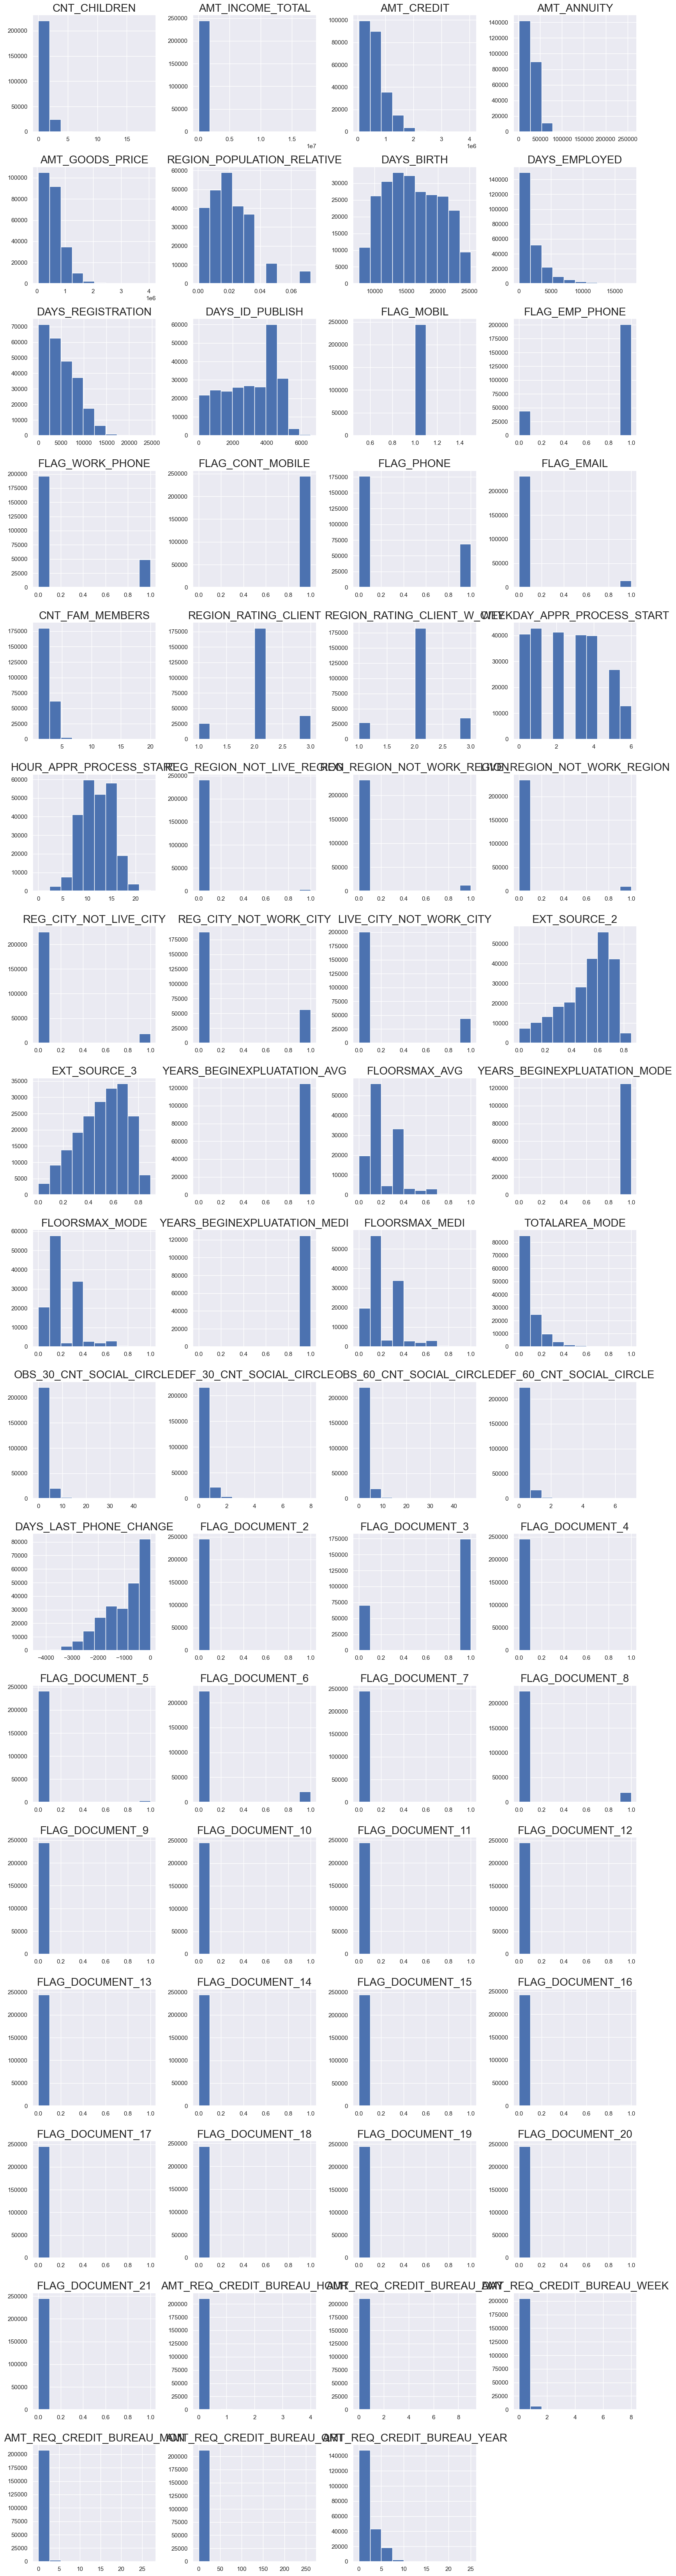

In [22]:
#Loading visualization functions present in the functions.py file
from functions import *

#Visualizing distribution of all numeric variables
histPlotAll(df)

#Apart from HOUR_APPR_PROCESS_START, all numeric variables seem to be not normally distributed

In [23]:
from scipy import stats

#Defining a data imputation function, we will use the NAME_CONTRACT_TYPE as a category_column

#This data_imputation script can be improved during the hyperparameter setting phase

def numeric_data_imputation(df: pd.DataFrame, category_column: str):
    
    #Creating a copy of our dataset
    df_imput = df.copy()
    #Creating a list of columns with missing values
    missing_cols = df.columns[df.isna().any()].tolist()
    max_unique_values = 3
    
    #Iterating over columns with missing data
    for c in missing_cols:
        
        #Verifying that we are in a numeric column
        if np.issubdtype(df[c].dtype,np.number):
            
            #If there are less or equal to max unique values, we will use mode imputation 
            if len(df[c].unique()) <= max_unique_values:
                            
                #We will create a subset from our categorical variable and perform mode imputation
                for t in df[category_column].unique():
                    #Creating subset
                    subset = df.loc[df[category_column] == t]
                    
                    #Calculating mode of subset
                    mode = subset[c].mode().values[0]
                    
                    #Applying imputation
                    df.loc[(df[c].isna()) & (df[category_column] == t), c] = mode
                    
            #If we have more numeric values, we will calculate the Kolmogorov Smirnoff pvalue to test for normalization
            else:
                
                #Normalizing target variable
                norm = c + '_norm'
                df_imput[norm] = (df_imput[c] - np.mean(df_imput[c].dropna())) / np.std(df_imput[c].dropna())

                #Calculating pvalue of KS test
                pval = stats.kstest(df_imput[norm].dropna(), 'norm').pvalue
                
                if pval >= 0.05:
                    #P value is superior to 0.05, we cannot reject the null hypothesis and thus conclude the variable is
                    #approximatively normally distributed
                    #We will use mean imputation on that variable
                    for t in df[category_column].unique():
                        #Creating subset
                        subset = df.loc[df[category_column] == t]

                        #Calculating mean based on that subset and our target column
                        mean = subset[c].mean()

                        #Applying imputation
                        df.loc[(df[c].isna()) & (df[category_column] == t), c] = mean
                else:
                    #P value is inferior to 0.05, we can reject the null hypothesis and thus conclude the variable is
                    #not normally distributed
                    #We will use median imputation on that variable
                    for t in df[category_column].unique():
                        #Creating subset
                        subset = df.loc[df[category_column] == t]

                        #Calculating mean based on that subset and our target column
                        med = subset[c].median()

                        #Applying imputation
                        df.loc[(df[c].isna()) & (df[category_column] == t), c] = med
    return None

#Applying the function to our 3 sets (X_train has been renamed to df)
numeric_data_imputation(df, 'NAME_CONTRACT_TYPE')
numeric_data_imputation(X_test, 'NAME_CONTRACT_TYPE')
numeric_data_imputation(X_val, 'NAME_CONTRACT_TYPE')

#Checking for nulls in our 3 sets
for data in [df,X_test,X_val]:
    print(np.count_nonzero(data.isnull()))
    
#We have no more NA values in all 3 sets

0
0
0


Now that we have 3 complete datasets, we can perform **feature engineering**

## 3. Feature Engineering

We will begin by encoding cyclical features.

### 3.1 Encoding Cyclical Features

We have 2 columns with time features that are cyclical in nature but coded with numbers.

- WEEDKAY_APPR_PROCESS_START
- HOUR_APPR_PROCESS_START

To increase the performance of our algorithm, we will apply a cyclical encoding algorithm to better represent their cyclical nature :

In [24]:
def encode_cyclical_vars(df: pd.DataFrame, cyclical_vars: list):
    for c in cyclical_vars:
        #Calculating the number of unique values
        n = len(df[c].unique())
        #Defining variable names
        cos_var = c + '_cos'
        sin_var = c + '_sin'
        #Calculating cyclical encoder variables
        df[sin_var] = np.sin(df[c] * (2*np.pi/n))
        df[cos_var] = np.cos(df[c] * (2*np.pi/n))
        #Dropping the base columns
        df.drop(columns = {c}, inplace=True)

cyclical_vars = ["WEEKDAY_APPR_PROCESS_START", "HOUR_APPR_PROCESS_START"]
encode_cyclical_vars(df, cyclical_vars)
encode_cyclical_vars(X_test, cyclical_vars)
encode_cyclical_vars(X_val, cyclical_vars)

df.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,WEEKDAY_APPR_PROCESS_START_sin,WEEKDAY_APPR_PROCESS_START_cos,HOUR_APPR_PROCESS_START_sin,HOUR_APPR_PROCESS_START_cos
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
250250,Cash loans,F,Y,Y,1,135000.0,67500.0,4441.5,67500.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.019101,15481,2874,9074.0,2353,1,1,0,1,0,0,Private service staff,3.0,2,2,1,1,0,1,1,0,Business Entity Type 3,0.635170,0.680139,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0685,UKN,0.0,0.0,0.0,0.0,-883.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.433884,-0.900969,-0.965926,-2.588190e-01
358425,Cash loans,F,N,N,0,180000.0,508495.5,22396.5,454500.0,Unaccompanied,Pensioner,Higher education,Separated,House / apartment,0.010006,22775,0,8376.0,4019,1,0,0,1,0,0,UKN,1.0,2,2,0,0,0,0,0,0,XNA,0.207382,0.104795,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0685,No,0.0,0.0,0.0,0.0,-74.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0,0.433884,-0.900969,0.258819,-9.659258e-01
230522,Cash loans,F,N,Y,0,81000.0,700830.0,20619.0,585000.0,Unaccompanied,State servant,Secondary / secondary special,Married,House / apartment,0.002042,19347,3229,11818.0,2824,1,1,1,1,0,0,High skill tech staff,2.0,3,3,0,0,0,0,1,1,Electricity,0.503058,0.692559,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0685,UKN,5.0,1.0,5.0,0.0,-563.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1.000000,0.707107,-7.071068e-01
248983,Cash loans,F,N,Y,0,67500.0,679266.0,19597.5,567000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.018209,23432,0,9755.0,4177,1,0,0,1,1,0,UKN,2.0,3,3,0,0,0,0,0,0,XNA,0.415605,0.657784,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0685,UKN,1.0,0.0,1.0,0.0,-5.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.781831,0.623490,0.866025,-5.000000e-01
196041,Cash loans,F,N,Y,0,58500.0,544491.0,15916.5,454500.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.020246,21565,0,3563.0,4588,1,0,0,1,0,0,UKN,1.0,3,3,0,0,0,0,0,0,XNA,0.357789,0.556727,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0685,UKN,4.0,1.0,4.0,1.0,-1914.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.781831,0.623490,1.000000,6.123234e-17


In [25]:
from category_encoders.one_hot import OneHotEncoder

ohe_cols = []
woe_cols = []
for c in df.columns:
        
    #Keeping only categorical columns
    if not np.issubdtype(df[c].dtype,np.number):

        #If more than X categories, performing WOE encoding
        if len(df[c].unique()) >= 10:
            woe_cols.append(c)

        else: 
            #One hot encoding and remove the original column
            ohe_cols.append(c)
            
enc = OneHotEncoder(cols=ohe_cols, return_df= True, drop_invariant=True).fit(df)
ohe_encoded_data = enc.transform(df)

ohe_encoded_data

,NAME_CONTRACT_TYPE_1,NAME_CONTRACT_TYPE_2,CODE_GENDER_1,CODE_GENDER_2,FLAG_OWN_CAR_1,FLAG_OWN_CAR_2,FLAG_OWN_REALTY_1,FLAG_OWN_REALTY_2,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE_1,NAME_TYPE_SUITE_2,NAME_TYPE_SUITE_3,NAME_TYPE_SUITE_4,NAME_TYPE_SUITE_5,NAME_TYPE_SUITE_6,NAME_TYPE_SUITE_7,NAME_INCOME_TYPE_1,NAME_INCOME_TYPE_2,NAME_INCOME_TYPE_3,NAME_INCOME_TYPE_4,NAME_EDUCATION_TYPE_1,NAME_EDUCATION_TYPE_2,NAME_EDUCATION_TYPE_3,NAME_EDUCATION_TYPE_4,NAME_EDUCATION_TYPE_5,NAME_FAMILY_STATUS_1,NAME_FAMILY_STATUS_2,NAME_FAMILY_STATUS_3,NAME_FAMILY_STATUS_4,NAME_FAMILY_STATUS_5,NAME_HOUSING_TYPE_1,NAME_HOUSING_TYPE_2,NAME_HOUSING_TYPE_3,NAME_HOUSING_TYPE_4,NAME_HOUSING_TYPE_5,NAME_HOUSING_TYPE_6,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,...,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE_1,EMERGENCYSTATE_MODE_2,EMERGENCYSTATE_MODE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,WEEKDAY_APPR_PROCESS_START_sin,WEEKDAY_APPR_PROCESS_START_cos,HOUR_APPR_PROCESS_START_sin,HOUR_APPR_PROCESS_START_cos
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
250250,1,0,1,0,1,0,1,0,1,135000.0,67500.0,4441.5,67500.0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.019101,15481,2874,9074.0,2353,1,1,0,1,0,...,1,0,Business Entity Type 3,0.635170,0.680139,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0685,1,0,0,0.0,0.0,0.0,0.0,-883.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.433884,-0.900969,-9.659258e-01,-2.588190e-01
358425,1,0,1,0,0,1,0,1,0,180000.0,508495.5,22396.5,454500.0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0.010006,22775,0,8376.0,4019,1,0,0,1,0,...,0,0,XNA,0.207382,0.104795,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0685,0,1,0,0.0,0.0,0.0,0.0,-74.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0,0.433884,-0.900969,2.588190e-01,-9.659258e-01
230522,1,0,1,0,0,1,1,0,0,81000.0,700830.0,20619.0,585000.0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.002042,19347,3229,11818.0,2824,1,1,1,1,0,...,1,1,Electricity,0.503058,0.692559,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0685,1,0,0,5.0,1.0,5.0,0.0,-563.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1.000000,7.071068e-01,-7.071068e-01
248983,1,0,1,0,0,1,1,0,0,67500.0,679266.0,19597.5,567000.0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.018209,23432,0,9755.0,4177,1,0,0,1,1,...,0,0,XNA,0.415605,0.657784,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0685,1,0,0,1.0,0.0,1.0,0.0,-5.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.781831,0.623490,8.660254e-01,-5.000000e-01
196041,1,0,1,0,0,1,1,0,0,58500.0,544491.0,15916.5,454500.0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0.020246,21565,0,3563.0,4588,1,0,0,1,0,...,0,0,XNA,0.357789,0.556727,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0685,1,0,0,4.0,1.0,4.0,1.0,-1914.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.781831,0.623490,1.000000e+00,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

### 3.2 Encoding categorical variables

Since our algorithms are only able to use numeric variables, we will need to **encode categorical variables**.

For variables with a small number of categories, we will perform **One-Hot Encoding**.

If there are more than 10 categories, we will perform **Weight of Evidence (WoE) encoding** instead to avoid a sharp increase in the dimensionality of our dataset.

In [26]:
from category_encoders import WOEEncoder
from category_encoders.one_hot import OneHotEncoder


def encode_cat_vars(df: pd.DataFrame, X_train: pd.DataFrame, y_train, max_categ: int):
    woe_cols = []
    ohe_cols = []
    for c in X_train.columns:
        
        #Keeping only categorical columns
        if not np.issubdtype(X_train[c].dtype,np.number):
            
            #If more than X categories, performing WOE encoding
            if len(X_train[c].unique()) >= max_categ:
                woe_cols.append(c)
            
            else: 
                #One hot encoding and remove the original column
                ohe_cols.append(c)
    
    #Defining WOE Encoder and fitting it to the TRAIN dataset
    woe_encoder = WOEEncoder(cols = woe_cols, return_df=True, drop_invariant=True).fit(X_train, y_train)
    X_train_encoded = woe_encoder.transform(X_train)
    #Fitting the encoder to the selected dataframe
    df = woe_encoder.transform(df)
    
    #Performing one hot encoding on selected columns
    ohe_encoder = OneHotEncoder(cols=ohe_cols, return_df= True, drop_invariant=True).fit(X_train_encoded)
    df = ohe_encoder.transform(df)
    
    
    del X_train_encoded
    return df

#Just a reminder that once again df = X_train
#We apply all this function to our 3 sets
X_test = encode_cat_vars(X_test, df, y_train, 10)
X_val = encode_cat_vars(X_val, df, y_train, 10)
df = encode_cat_vars(df, df, y_train, 10)

In [27]:
def check_dtypes(df: pd.DataFrame):
    type_cols = []
    for c in df.columns:
        if not np.isin(df[c].dtype, type_cols):
            type_cols.append(df[c].dtype)
    print(type_cols)

check_dtypes(df)
check_dtypes(X_test)
check_dtypes(X_val)

[dtype('int64'), dtype('float64')]
[dtype('int64'), dtype('float64')]
[dtype('int64'), dtype('float64')]


In [28]:
print(df.shape, X_test.shape, X_val.shape)

(244971, 109) (30622, 109) (30622, 109)


We have verified that all of our 3 sets are composed only of numeric features and that they have the same number of columns.

We will now use **additional features from other dataframes** to increase the performance of our models.

### 3.3 Using previous application data

In [29]:
prev_app = pd.read_csv("Data/previous_application.csv", sep=",")

prev_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [30]:
prev_app.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,5951.000000,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,0.188357,0.773503,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,0.087671,0.100879,7.790997e+02,7.127443e+03,1.456729e+01,88916.115834,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,0.034781,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,0.160716,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,0.189122,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,0.193330,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,1.000000,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


In [31]:
#We are interesting in DAYS_LAST_DUE (the number of days the borrower has to pay previous applications)
#But there are illogical values (365243 which is equal to 1000 years)
#First we'll replace all the values by 0
prev_app.loc[prev_app.DAYS_LAST_DUE > 300000, "DAYS_LAST_DUE"] = 0

#Defining current amount due, we have to add a negative sign because DAYS_LAST_DUE is negative
prev_app["curr_amount_due"] = -prev_app["AMT_ANNUITY"]*prev_app["DAYS_LAST_DUE"]/365

prev_app["curr_annuity"] = 0
prev_app.loc[prev_app["DAYS_LAST_DUE"] < 0, "curr_annuity"] = prev_app["AMT_ANNUITY"]
prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,curr_amount_due,curr_annuity
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,199.117973,1730.430
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,0.0,365243.0,1.0,-0.000000,0.000
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,0.0,365243.0,1.0,-0.000000,0.000
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,23456.227315,47041.335
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000


In [32]:
#Verifying unique values of contract status
prev_app.NAME_CONTRACT_STATUS.unique()
#4 categories, Approved, Refused, Canceled and Unused offer

prev_app["AMT_GRANTED"] = 0
prev_app.loc[prev_app["NAME_CONTRACT_STATUS"] == "Approved", "AMT_GRANTED"] = prev_app["AMT_CREDIT"]

prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,curr_amount_due,curr_annuity,AMT_GRANTED
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,199.117973,1730.430,17145.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,0.0,365243.0,1.0,-0.000000,0.000,679671.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,0.0,365243.0,1.0,-0.000000,0.000,136444.5
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,23456.227315,47041.335,470790.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.0


In [33]:
#We will aggregate by SK_ID_CURR and retrieve important information about previous applications :
prev_app_numbers = prev_app.groupby("SK_ID_CURR").agg(curr_amount_due = ('curr_amount_due', 'sum'), n_prev_app = ('SK_ID_PREV', 'count'),
                                  curr_annuity_due = ('curr_annuity', 'sum'), amount_requested = ('AMT_APPLICATION', 'sum'),
                                  amount_granted = ('AMT_GRANTED', 'sum'))

prev_app_numbers.head()

,curr_amount_due,n_prev_app,curr_annuity_due,amount_requested,amount_granted
SK_ID_CURR,,,,,
100001,17525.120548,1,3951.000,24835.5,23787.0
100002,633.683219,1,9251.775,179055.0,179055.0
100003,295436.992808,3,169661.970,1306309.5,1452573.0
100004,10626.435616,1,5357.250,24282.0,20106.0
100005,6145.071781,2,4813.200,44617.5,40153.5


In [34]:
#Creating a dataframe with the number of each different name contract status by SK_ID_CURR
prev_app_status = pd.crosstab(prev_app['SK_ID_CURR'], prev_app['NAME_CONTRACT_STATUS'])

prev_app_status.columns = ["n_prev_app_approved","n_prev_app_canceled","n_prev_app_refused","n_prev_app_unused"]
prev_app_status.head()

,n_prev_app_approved,n_prev_app_canceled,n_prev_app_refused,n_prev_app_unused
SK_ID_CURR,,,,
100001,1,0,0,0
100002,1,0,0,0
100003,3,0,0,0
100004,1,0,0,0
100005,1,1,0,0


In [35]:
prev_app_df = pd.merge(prev_app_numbers, prev_app_status, how='inner', left_index=True, right_index=True)

prev_app_df.head()

,curr_amount_due,n_prev_app,curr_annuity_due,amount_requested,amount_granted,n_prev_app_approved,n_prev_app_canceled,n_prev_app_refused,n_prev_app_unused
SK_ID_CURR,,,,,,,,,
100001,17525.120548,1,3951.000,24835.5,23787.0,1,0,0,0
100002,633.683219,1,9251.775,179055.0,179055.0,1,0,0,0
100003,295436.992808,3,169661.970,1306309.5,1452573.0,3,0,0,0
100004,10626.435616,1,5357.250,24282.0,20106.0,1,0,0,0
100005,6145.071781,2,4813.200,44617.5,40153.5,1,1,0,0


In [36]:
#Joining this new data and filling NAs with 0 (since it means there was no previous application)
df = pd.merge(df, prev_app_df, how='left', left_index=True, right_index=True).fillna(0)
X_test = pd.merge(X_test, prev_app_df, how='left', left_index=True, right_index=True).fillna(0)
X_val = pd.merge(X_val, prev_app_df, how='left', left_index=True, right_index=True).fillna(0)

X_val.head()

,NAME_CONTRACT_TYPE_1,NAME_CONTRACT_TYPE_2,CODE_GENDER_1,CODE_GENDER_2,FLAG_OWN_CAR_1,FLAG_OWN_CAR_2,FLAG_OWN_REALTY_1,FLAG_OWN_REALTY_2,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE_1,NAME_TYPE_SUITE_2,NAME_TYPE_SUITE_3,NAME_TYPE_SUITE_4,NAME_TYPE_SUITE_5,NAME_TYPE_SUITE_6,NAME_TYPE_SUITE_7,NAME_INCOME_TYPE_1,NAME_INCOME_TYPE_2,NAME_INCOME_TYPE_3,NAME_INCOME_TYPE_4,NAME_EDUCATION_TYPE_1,NAME_EDUCATION_TYPE_2,NAME_EDUCATION_TYPE_3,NAME_EDUCATION_TYPE_4,NAME_EDUCATION_TYPE_5,NAME_FAMILY_STATUS_1,NAME_FAMILY_STATUS_2,NAME_FAMILY_STATUS_3,NAME_FAMILY_STATUS_4,NAME_FAMILY_STATUS_5,NAME_HOUSING_TYPE_1,NAME_HOUSING_TYPE_2,NAME_HOUSING_TYPE_3,NAME_HOUSING_TYPE_4,NAME_HOUSING_TYPE_5,NAME_HOUSING_TYPE_6,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,...,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE_1,EMERGENCYSTATE_MODE_2,EMERGENCYSTATE_MODE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,WEEKDAY_APPR_PROCESS_START_sin,WEEKDAY_APPR_PROCESS_START_cos,HOUR_APPR_PROCESS_START_sin,HOUR_APPR_PROCESS_START_cos,curr_amount_due,n_prev_app,curr_annuity_due,amount_requested,amount_granted,n_prev_app_approved,n_prev_app_canceled,n_prev_app_refused,n_prev_app_unused
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
241993,1,0,1,0,0,1,0,1,0,67500.0,675000.0,18099.0,675000.0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.026392,19096,1824,5435.0,2636,1,1,1,1,1,...,0.9816,0.1667,0.0685,1,0,0,0.0,0.0,0.0,0.0,-1488.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.781831,0.623490,5.000000e-01,-0.866025,133020.943274,5.0,39441.150,450900.0,521320.5,4.0,0.0,1.0,0.0
335681,1,0,0,1,1,0,0,1,2,202500.0,314100.0,16164.0,225000.0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.035792,14256,2221,4074.0,4065,1,1,0,1,0,...,0.9816,0.1667,0.0685,1,0,0,2.0,0.0,1.0,0.0,-2988.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.781831,0.623490,-7.071068e-01,-0.707107,6400.263082,3.0,7909.830,101160.0,108355.5,3.0,0.0,0.0,0.0
128638,1,0,1,0,1,0,1,0,1,117000.0,675000.0,32602.5,675000.0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.010966,15304,5287,8399.0,5038,1,1,0,1,0,...,0.9816,0.1667,0.0685,1,0,0,2.0,0.0,2.0,0.0,-358.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0,0.000000,1.000000,5.000000e-01,-0.866025,7192.846356,4.0,7076.520,167962.5,121774.5,2.0,1.0,1.0,0.0
221651,1,0,1,0,0,1,1,0,0,103500.0,808650.0,24732.0,675000.0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0.020713,17563,804,4586.0,1094,1,1,0,1,0,...,0.9816,0.1667,0.0685,1,0,0,1.0,0.0,1.0,0.0,-203.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.433884,-0.900969,1.224647e-16,-1.000000,40003.288767,2.0,7381.800,288090.0,307017.0,2.0,0.0,0.0,0.0
280436,1,0,1,0,0,1,0,1,0,31500.0,545040.0,25407.0,450000.0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0.018209,21824,0,4810.0,4819,1,0,0,1,1,...,0.9816,0.1667,0.0685,1,0,0,0.0,0.0,0.0,0.0,-140.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,0.974928,-0.222521,9.659258e-01,-0.258819,3333.700233,3.0,8509.095,66532.5,72387.0,1.0,0.0,2.0,0.0


### 3.4 Using Credit Bureau information

We also have information about CB for each borrower that we can use to increase the accuracy of our model:

In [37]:
bureau = pd.read_csv("Data/bureau.csv", sep=",")

bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [38]:
bureau.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08


In [39]:
print(bureau.CREDIT_ACTIVE.unique())
print(bureau.CREDIT_CURRENCY.unique())

len(bureau[bureau.CREDIT_CURRENCY.isna()])
#Credit active is interesting because of the bad debt field
#Currency is also interesting because it could be an indicator to fraudulent transactions

['Closed' 'Active' 'Sold' 'Bad debt']
['currency 1' 'currency 2' 'currency 4' 'currency 3']


0

In [40]:
#We will count the number of CB credits with each of these attributes :
bureau_categ1 = pd.crosstab(bureau['SK_ID_CURR'], bureau['CREDIT_ACTIVE'])
bureau_categ2 = pd.crosstab(bureau['SK_ID_CURR'], bureau['CREDIT_CURRENCY'])

bureau_categ = pd.merge(bureau_categ1, bureau_categ2, how="outer", left_index=True, right_index=True)

bureau_categ.columns = ['n_CB_active', 'n_CB_bad_debt', 'n_CB_closed', 'n_CB_sold',
                        'n_CB_curr1','n_CB_curr2','n_CB_curr3','n_CB_curr4']

bureau_categ.head()

,n_CB_active,n_CB_bad_debt,n_CB_closed,n_CB_sold,n_CB_curr1,n_CB_curr2,n_CB_curr3,n_CB_curr4
SK_ID_CURR,,,,,,,,
100001,3,0,4,0,7,0,0,0
100002,2,0,6,0,8,0,0,0
100003,1,0,3,0,4,0,0,0
100004,0,0,2,0,2,0,0,0
100005,2,0,1,0,3,0,0,0


In [41]:
#We will now aggreagte over SK_ID_CURR to calculate relevant numeric features 

bureau_num = bureau.groupby("SK_ID_CURR").agg(
    total_days_CB_overdue = ('CREDIT_DAY_OVERDUE', 'sum'), max_CB_overdue = ('AMT_CREDIT_MAX_OVERDUE', 'max'),
    avg_prolonged = ('CNT_CREDIT_PROLONG' , 'mean'), CB_credit = ('AMT_CREDIT_SUM','sum'),
    CB_debt = ('AMT_CREDIT_SUM_DEBT','sum'), CB_credit_limit = ('AMT_CREDIT_SUM_LIMIT', 'sum'),
    CB_overdue = ('AMT_CREDIT_SUM_OVERDUE','sum'), CB_total_annuity = ('AMT_ANNUITY', 'sum')
)

bureau_num.info()
#We only have null values for max_CB_overdue, we will replace null values by 0 because it probably means there was never
#An overdue amount

bureau_num = bureau_num.fillna(0)
bureau_num.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305811 entries, 100001 to 456255
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   total_days_CB_overdue  305811 non-null  int64  
 1   max_CB_overdue         212971 non-null  float64
 2   avg_prolonged          305811 non-null  float64
 3   CB_credit              305811 non-null  float64
 4   CB_debt                305811 non-null  float64
 5   CB_credit_limit        305811 non-null  float64
 6   CB_overdue             305811 non-null  float64
 7   CB_total_annuity       305811 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 21.0 MB


,total_days_CB_overdue,max_CB_overdue,avg_prolonged,CB_credit,CB_debt,CB_credit_limit,CB_overdue,CB_total_annuity
SK_ID_CURR,,,,,,,,
100001,0,0.000,0.0,1453365.000,596686.5,0.000,0.0,24817.5
100002,0,5043.645,0.0,865055.565,245781.0,31988.565,0.0,0.0
100003,0,0.000,0.0,1017400.500,0.0,810000.000,0.0,0.0
100004,0,0.000,0.0,189037.800,0.0,0.000,0.0,0.0
100005,0,0.000,0.0,657126.000,568408.5,0.000,0.0,4261.5


In [42]:
#We now load the bureau_balance csv file
bureau_balance = pd.read_csv("Data/bureau_balance.csv", sep=',')

bureau_balance.STATUS.value_counts(normalize=True)

C    0.499891
0    0.274708
X    0.212839
1    0.008877
5    0.002286
2    0.000858
3    0.000327
4    0.000214
Name: STATUS, dtype: float64

In [43]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [44]:
#We create a crosstab to count the number of status type for each sk_id_bureau
bureau_balance_stats = pd.crosstab(bureau_balance['SK_ID_BUREAU'], bureau_balance['STATUS'])

bureau_balance_stats.head()

STATUS,0,1,2,3,4,5,C,X
SK_ID_BUREAU,,,,,,,,
5001709,0,0,0,0,0,0,86,11
5001710,5,0,0,0,0,0,48,30
5001711,3,0,0,0,0,0,0,1
5001712,10,0,0,0,0,0,9,0
5001713,0,0,0,0,0,0,0,22


In [45]:
#Renaming the columns for better clarity
bureau_balance_stats.columns=["cb_dpd_0","cb_dpd_1","cb_dpd_2","cb_dpd_3","cb_dpd_4","cb_dpd_5","cb_bal_closed","cb_bal_ukn"]
bureau_balance_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817395 entries, 5001709 to 6842888
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   cb_dpd_0       817395 non-null  int64
 1   cb_dpd_1       817395 non-null  int64
 2   cb_dpd_2       817395 non-null  int64
 3   cb_dpd_3       817395 non-null  int64
 4   cb_dpd_4       817395 non-null  int64
 5   cb_dpd_5       817395 non-null  int64
 6   cb_bal_closed  817395 non-null  int64
 7   cb_bal_ukn     817395 non-null  int64
dtypes: int64(8)
memory usage: 56.1 MB


In [46]:
#Joining with the main CB dataframe to retrieve SK_ID_CURR info
bureau_num_bal = pd.merge(bureau_balance_stats, bureau[["SK_ID_BUREAU","SK_ID_CURR"]], how='inner', left_index=True, right_on='SK_ID_BUREAU')

#Aggregating by SK_ID_CURR
bureau_num_bal = bureau_num_bal.groupby("SK_ID_CURR").sum()

#Dropping the now useless SK_ID_BUREAU column
bureau_num_bal.drop(columns={"SK_ID_BUREAU"}, inplace=True)

bureau_num_bal.head()

,cb_dpd_0,cb_dpd_1,cb_dpd_2,cb_dpd_3,cb_dpd_4,cb_dpd_5,cb_bal_closed,cb_bal_ukn
SK_ID_CURR,,,,,,,,
100001,31,1,0,0,0,0,110,30
100002,45,27,0,0,0,0,23,15
100005,14,0,0,0,0,0,5,2
100010,20,0,0,0,0,0,52,0
100013,79,7,0,0,0,0,103,41


In [47]:
bureau_num_bal.info()
#We only have 134k different SK_ID, which is about 40% of our dataset. 
#We will fill nulls with 0 because it means that the other SK_ID were not referenced at the Credit Bureau

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134542 entries, 100001 to 456255
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   cb_dpd_0       134542 non-null  int64
 1   cb_dpd_1       134542 non-null  int64
 2   cb_dpd_2       134542 non-null  int64
 3   cb_dpd_3       134542 non-null  int64
 4   cb_dpd_4       134542 non-null  int64
 5   cb_dpd_5       134542 non-null  int64
 6   cb_bal_closed  134542 non-null  int64
 7   cb_bal_ukn     134542 non-null  int64
dtypes: int64(8)
memory usage: 9.2 MB


In [48]:
#Filling nulls with 0 as mentionned previously
bureau_num_full = pd.merge(bureau_num, bureau_num_bal, how='outer', left_index=True, right_index=True).fillna(0)

bureau_num_full.info()
bureau_num_full.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305811 entries, 100001 to 456255
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   total_days_CB_overdue  305811 non-null  int64  
 1   max_CB_overdue         305811 non-null  float64
 2   avg_prolonged          305811 non-null  float64
 3   CB_credit              305811 non-null  float64
 4   CB_debt                305811 non-null  float64
 5   CB_credit_limit        305811 non-null  float64
 6   CB_overdue             305811 non-null  float64
 7   CB_total_annuity       305811 non-null  float64
 8   cb_dpd_0               305811 non-null  float64
 9   cb_dpd_1               305811 non-null  float64
 10  cb_dpd_2               305811 non-null  float64
 11  cb_dpd_3               305811 non-null  float64
 12  cb_dpd_4               305811 non-null  float64
 13  cb_dpd_5               305811 non-null  float64
 14  cb_bal_closed          305811 n

,total_days_CB_overdue,max_CB_overdue,avg_prolonged,CB_credit,CB_debt,CB_credit_limit,CB_overdue,CB_total_annuity,cb_dpd_0,cb_dpd_1,cb_dpd_2,cb_dpd_3,cb_dpd_4,cb_dpd_5,cb_bal_closed,cb_bal_ukn
SK_ID_CURR,,,,,,,,,,,,,,,,
100001,0,0.000,0.0,1453365.000,596686.5,0.000,0.0,24817.5,31.0,1.0,0.0,0.0,0.0,0.0,110.0,30.0
100002,0,5043.645,0.0,865055.565,245781.0,31988.565,0.0,0.0,45.0,27.0,0.0,0.0,0.0,0.0,23.0,15.0
100003,0,0.000,0.0,1017400.500,0.0,810000.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,0.000,0.0,189037.800,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100005,0,0.000,0.0,657126.000,568408.5,0.000,0.0,4261.5,14.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0


In [49]:
#Merging the 2 dataframes with bureau information
bureau_df = pd.merge(bureau_categ, bureau_num_full, how='outer', left_index=True, right_index=True)

print(bureau_df.isna().sum().sum())
#No null values
bureau_df.head()

0


,n_CB_active,n_CB_bad_debt,n_CB_closed,n_CB_sold,n_CB_curr1,n_CB_curr2,n_CB_curr3,n_CB_curr4,total_days_CB_overdue,max_CB_overdue,avg_prolonged,CB_credit,CB_debt,CB_credit_limit,CB_overdue,CB_total_annuity,cb_dpd_0,cb_dpd_1,cb_dpd_2,cb_dpd_3,cb_dpd_4,cb_dpd_5,cb_bal_closed,cb_bal_ukn
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,0,4,0,7,0,0,0,0,0.000,0.0,1453365.000,596686.5,0.000,0.0,24817.5,31.0,1.0,0.0,0.0,0.0,0.0,110.0,30.0
100002,2,0,6,0,8,0,0,0,0,5043.645,0.0,865055.565,245781.0,31988.565,0.0,0.0,45.0,27.0,0.0,0.0,0.0,0.0,23.0,15.0
100003,1,0,3,0,4,0,0,0,0,0.000,0.0,1017400.500,0.0,810000.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,0,2,0,2,0,0,0,0,0.000,0.0,189037.800,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100005,2,0,1,0,3,0,0,0,0,0.000,0.0,657126.000,568408.5,0.000,0.0,4261.5,14.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0


In [50]:
#Just as before, we join our CB information with our 3 dataframes and replace na values by 0
df = pd.merge(df, bureau_df, how='left', left_index=True, right_index=True).fillna(0)
X_test = pd.merge(X_test, bureau_df, how='left', left_index=True, right_index=True).fillna(0)
X_val = pd.merge(X_val, bureau_df, how='left', left_index=True, right_index=True).fillna(0)

X_val.head()

,NAME_CONTRACT_TYPE_1,NAME_CONTRACT_TYPE_2,CODE_GENDER_1,CODE_GENDER_2,FLAG_OWN_CAR_1,FLAG_OWN_CAR_2,FLAG_OWN_REALTY_1,FLAG_OWN_REALTY_2,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE_1,NAME_TYPE_SUITE_2,NAME_TYPE_SUITE_3,NAME_TYPE_SUITE_4,NAME_TYPE_SUITE_5,NAME_TYPE_SUITE_6,NAME_TYPE_SUITE_7,NAME_INCOME_TYPE_1,NAME_INCOME_TYPE_2,NAME_INCOME_TYPE_3,NAME_INCOME_TYPE_4,NAME_EDUCATION_TYPE_1,NAME_EDUCATION_TYPE_2,NAME_EDUCATION_TYPE_3,NAME_EDUCATION_TYPE_4,NAME_EDUCATION_TYPE_5,NAME_FAMILY_STATUS_1,NAME_FAMILY_STATUS_2,NAME_FAMILY_STATUS_3,NAME_FAMILY_STATUS_4,NAME_FAMILY_STATUS_5,NAME_HOUSING_TYPE_1,NAME_HOUSING_TYPE_2,NAME_HOUSING_TYPE_3,NAME_HOUSING_TYPE_4,NAME_HOUSING_TYPE_5,NAME_HOUSING_TYPE_6,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,...,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,WEEKDAY_APPR_PROCESS_START_sin,WEEKDAY_APPR_PROCESS_START_cos,HOUR_APPR_PROCESS_START_sin,HOUR_APPR_PROCESS_START_cos,curr_amount_due,n_prev_app,curr_annuity_due,amount_requested,amount_granted,n_prev_app_approved,n_prev_app_canceled,n_prev_app_refused,n_prev_app_unused,n_CB_active,n_CB_bad_debt,n_CB_closed,n_CB_sold,n_CB_curr1,n_CB_curr2,n_CB_curr3,n_CB_curr4,total_days_CB_overdue,max_CB_overdue,avg_prolonged,CB_credit,CB_debt,CB_credit_limit,CB_overdue,CB_total_annuity,cb_dpd_0,cb_dpd_1,cb_dpd_2,cb_dpd_3,cb_dpd_4,cb_dpd_5,cb_bal_closed,cb_bal_ukn
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
241993,1,0,1,0,0,1,0,1,0,67500.0,675000.0,18099.0,675000.0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.026392,19096,1824,5435.0,2636,1,1,1,1,1,...,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.781831,0.623490,5.000000e-01,-0.866025,133020.943274,5.0,39441.150,450900.0,521320.5,4.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,6.0,0.0,0.0,0.0,0.0,0.000,0.0,1236735.0,448821.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
335681,1,0,0,1,1,0,0,1,2,202500.0,314100.0,16164.0,225000.0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.035792,14256,2221,4074.0,4065,1,1,0,1,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.781831,0.623490,-7.071068e-01,-0.707107,6400.263082,3.0,7909.830,101160.0,108355.5,3.0,0.0,0.0,0.0,3.0,0.0,8.0,0.0,11.0,0.0,0.0,0.0,0.0,0.000,0.0,3187719.0,1012675.5,0.000,0.0,18000.0,82.0,2.0,0.0,0.0,0.0,0.0,225.0,9.0
128638,1,0,1,0,1,0,1,0,1,117000.0,675000.0,32602.5,675000.0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.010966,15304,5287,8399.0,5038,1,1,0,1,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0,0.000000,1.000000,5.000000e-01,-0.866025,7192.846356,4.0,7076.520,167962.5,121774.5,2.0,1.0,1.0,0.0,2.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,20.0,0.000,0.0,538267.5,141048.0,67358.520,184.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221651,1,0,1,0,0,1,1,0,0,103500.0,808650.0,24732.0,675000.0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0.020713,17563,804,4586.0,1094,1,1,0,1,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.433884,-0.900969,1.224647e-16,-1.000000,40003.288767,2.0,7381.800,288090.0,307017.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000,0.0,103113.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
280436,1,0,1,0,0,1,0,1,0,31500.0,545040.0,25407.0,450000.0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0.018209,21824,0,4810.0,4819,1,0,0,1,1,...,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,0.974928,-0.222521,9.659258e-01,-0.258819,3333.700233,3.0,8509.095,66532.5,72387.0,1.0,0.0,2.0,0.0,10.0,0.0,4.0,0.0,14.0,0.0,0.0,0.0,0.0,7484.175,0.0,1751876.1,930910.5,5569.695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.5 Using Cash balance information

In [51]:
cash = pd.read_csv("Data/POS_CASH_balance.csv", sep=',')

cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [52]:
#We will extract both Day past due (DPD) informations that seem the most relevant
#We will use the DPD_DEF field because it removes low amounts debts
cash_df = cash[["SK_ID_CURR","SK_DPD_DEF"]].groupby("SK_ID_CURR").sum()

cash_df.head()

,SK_DPD_DEF
SK_ID_CURR,
100001,7
100002,0
100003,0
100004,0
100005,0


In [53]:
#We join our cash information with our 3 dataframes and replace na values by 0
df = pd.merge(df, cash_df, how='left', left_index=True, right_index=True).fillna(0)
X_test = pd.merge(X_test, cash_df, how='left', left_index=True, right_index=True).fillna(0)
X_val = pd.merge(X_val, cash_df, how='left', left_index=True, right_index=True).fillna(0)

X_val.head()

,NAME_CONTRACT_TYPE_1,NAME_CONTRACT_TYPE_2,CODE_GENDER_1,CODE_GENDER_2,FLAG_OWN_CAR_1,FLAG_OWN_CAR_2,FLAG_OWN_REALTY_1,FLAG_OWN_REALTY_2,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE_1,NAME_TYPE_SUITE_2,NAME_TYPE_SUITE_3,NAME_TYPE_SUITE_4,NAME_TYPE_SUITE_5,NAME_TYPE_SUITE_6,NAME_TYPE_SUITE_7,NAME_INCOME_TYPE_1,NAME_INCOME_TYPE_2,NAME_INCOME_TYPE_3,NAME_INCOME_TYPE_4,NAME_EDUCATION_TYPE_1,NAME_EDUCATION_TYPE_2,NAME_EDUCATION_TYPE_3,NAME_EDUCATION_TYPE_4,NAME_EDUCATION_TYPE_5,NAME_FAMILY_STATUS_1,NAME_FAMILY_STATUS_2,NAME_FAMILY_STATUS_3,NAME_FAMILY_STATUS_4,NAME_FAMILY_STATUS_5,NAME_HOUSING_TYPE_1,NAME_HOUSING_TYPE_2,NAME_HOUSING_TYPE_3,NAME_HOUSING_TYPE_4,NAME_HOUSING_TYPE_5,NAME_HOUSING_TYPE_6,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,...,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,WEEKDAY_APPR_PROCESS_START_sin,WEEKDAY_APPR_PROCESS_START_cos,HOUR_APPR_PROCESS_START_sin,HOUR_APPR_PROCESS_START_cos,curr_amount_due,n_prev_app,curr_annuity_due,amount_requested,amount_granted,n_prev_app_approved,n_prev_app_canceled,n_prev_app_refused,n_prev_app_unused,n_CB_active,n_CB_bad_debt,n_CB_closed,n_CB_sold,n_CB_curr1,n_CB_curr2,n_CB_curr3,n_CB_curr4,total_days_CB_overdue,max_CB_overdue,avg_prolonged,CB_credit,CB_debt,CB_credit_limit,CB_overdue,CB_total_annuity,cb_dpd_0,cb_dpd_1,cb_dpd_2,cb_dpd_3,cb_dpd_4,cb_dpd_5,cb_bal_closed,cb_bal_ukn,SK_DPD_DEF
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
241993,1,0,1,0,0,1,0,1,0,67500.0,675000.0,18099.0,675000.0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.026392,19096,1824,5435.0,2636,1,1,1,1,1,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.781831,0.623490,5.000000e-01,-0.866025,133020.943274,5.0,39441.150,450900.0,521320.5,4.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,6.0,0.0,0.0,0.0,0.0,0.000,0.0,1236735.0,448821.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
335681,1,0,0,1,1,0,0,1,2,202500.0,314100.0,16164.0,225000.0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.035792,14256,2221,4074.0,4065,1,1,0,1,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.781831,0.623490,-7.071068e-01,-0.707107,6400.263082,3.0,7909.830,101160.0,108355.5,3.0,0.0,0.0,0.0,3.0,0.0,8.0,0.0,11.0,0.0,0.0,0.0,0.0,0.000,0.0,3187719.0,1012675.5,0.000,0.0,18000.0,82.0,2.0,0.0,0.0,0.0,0.0,225.0,9.0,0.0
128638,1,0,1,0,1,0,1,0,1,117000.0,675000.0,32602.5,675000.0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.010966,15304,5287,8399.0,5038,1,1,0,1,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0,0.000000,1.000000,5.000000e-01,-0.866025,7192.846356,4.0,7076.520,167962.5,121774.5,2.0,1.0,1.0,0.0,2.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,20.0,0.000,0.0,538267.5,141048.0,67358.520,184.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221651,1,0,1,0,0,1,1,0,0,103500.0,808650.0,24732.0,675000.0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0.020713,17563,804,4586.0,1094,1,1,0,1,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.433884,-0.900969,1.224647e-16,-1.000000,40003.288767,2.0,7381.800,288090.0,307017.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000,0.0,103113.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0
280436,1,0,1,0,0,1,0,1,0,31500.0,545040.0,25407.0,450000.0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0.018209,21824,0,4810.0,4819,1,0,0,1,1,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,0.974928,-0.222521,9.659258e-01,-0.258819,3333.700233,3.0,8509.095,66532.5,72387.0,1.0,0.0,2.0,0.0,10.0,0.0,4.0,0.0,14.0,0.0,0.0,0.0,0.0,7484.175,0.0,1751876.1,930910.5,5569.695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.6 Using CC Balance information

In [54]:
cc = pd.read_csv("Data/credit_card_balance.csv",sep=",")

cc.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [55]:
#Investigating possible months balance values
cc.MONTHS_BALANCE.value_counts()

cc_df = cc.groupby("SK_ID_CURR").agg(
    total_cc_balance = ('AMT_BALANCE','sum'), cc_credit_lim = ('AMT_CREDIT_LIMIT_ACTUAL', 'sum'),
    total_cc_drawings = ('AMT_DRAWINGS_CURRENT','sum'), monthly_cc_payment = ('AMT_PAYMENT_TOTAL_CURRENT','sum'),
    total_cc_receivable = ('AMT_TOTAL_RECEIVABLE', 'sum'), n_cc_drawings = ('CNT_DRAWINGS_CURRENT','sum'),
    cc_dpd = ('SK_DPD_DEF', 'sum'))
cc_df.info()
cc_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103558 entries, 100006 to 456250
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   total_cc_balance     103558 non-null  float64
 1   cc_credit_lim        103558 non-null  int64  
 2   total_cc_drawings    103558 non-null  float64
 3   monthly_cc_payment   103558 non-null  float64
 4   total_cc_receivable  103558 non-null  float64
 5   n_cc_drawings        103558 non-null  int64  
 6   cc_dpd               103558 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 6.3 MB


,total_cc_balance,cc_credit_lim,total_cc_drawings,monthly_cc_payment,total_cc_receivable,n_cc_drawings,cc_dpd
SK_ID_CURR,,,,,,,
100006,0.000,1620000,0.0,0.000,0.000,0,0
100011,4031676.225,12150000,180000.0,334485.000,4028055.255,4,0
100013,1743352.245,12645000,571500.0,654448.545,1737703.665,23,1
100021,0.000,11475000,0.0,0.000,0.000,0,0
100023,0.000,1080000,0.0,0.000,0.000,0,0


In [56]:
#We join our CC information with our 3 dataframes and replace na values by 0
df = pd.merge(df, cc_df, how='left', left_index=True, right_index=True).fillna(0)
X_test = pd.merge(X_test, cc_df, how='left', left_index=True, right_index=True).fillna(0)
X_val = pd.merge(X_val, cc_df, how='left', left_index=True, right_index=True).fillna(0)

X_val.head()

,NAME_CONTRACT_TYPE_1,NAME_CONTRACT_TYPE_2,CODE_GENDER_1,CODE_GENDER_2,FLAG_OWN_CAR_1,FLAG_OWN_CAR_2,FLAG_OWN_REALTY_1,FLAG_OWN_REALTY_2,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE_1,NAME_TYPE_SUITE_2,NAME_TYPE_SUITE_3,NAME_TYPE_SUITE_4,NAME_TYPE_SUITE_5,NAME_TYPE_SUITE_6,NAME_TYPE_SUITE_7,NAME_INCOME_TYPE_1,NAME_INCOME_TYPE_2,NAME_INCOME_TYPE_3,NAME_INCOME_TYPE_4,NAME_EDUCATION_TYPE_1,NAME_EDUCATION_TYPE_2,NAME_EDUCATION_TYPE_3,NAME_EDUCATION_TYPE_4,NAME_EDUCATION_TYPE_5,NAME_FAMILY_STATUS_1,NAME_FAMILY_STATUS_2,NAME_FAMILY_STATUS_3,NAME_FAMILY_STATUS_4,NAME_FAMILY_STATUS_5,NAME_HOUSING_TYPE_1,NAME_HOUSING_TYPE_2,NAME_HOUSING_TYPE_3,NAME_HOUSING_TYPE_4,NAME_HOUSING_TYPE_5,NAME_HOUSING_TYPE_6,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,WEEKDAY_APPR_PROCESS_START_sin,WEEKDAY_APPR_PROCESS_START_cos,HOUR_APPR_PROCESS_START_sin,HOUR_APPR_PROCESS_START_cos,curr_amount_due,n_prev_app,curr_annuity_due,amount_requested,amount_granted,n_prev_app_approved,n_prev_app_canceled,n_prev_app_refused,n_prev_app_unused,n_CB_active,n_CB_bad_debt,n_CB_closed,n_CB_sold,n_CB_curr1,n_CB_curr2,n_CB_curr3,n_CB_curr4,total_days_CB_overdue,max_CB_overdue,avg_prolonged,CB_credit,CB_debt,CB_credit_limit,CB_overdue,CB_total_annuity,cb_dpd_0,cb_dpd_1,cb_dpd_2,cb_dpd_3,cb_dpd_4,cb_dpd_5,cb_bal_closed,cb_bal_ukn,SK_DPD_DEF,total_cc_balance,cc_credit_lim,total_cc_drawings,monthly_cc_payment,total_cc_receivable,n_cc_drawings,cc_dpd
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
241993,1,0,1,0,0,1,0,1,0,67500.0,675000.0,18099.0,675000.0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.026392,19096,1824,5435.0,2636,1,1,1,1,1,...,0.0,0.0,0.0,0.0,2.0,0.781831,0.623490,5.000000e-01,-0.866025,133020.943274,5.0,39441.150,450900.0,521320.5,4.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,6.0,0.0,0.0,0.0,0.0,0.000,0.0,1236735.0,448821.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
335681,1,0,0,1,1,0,0,1,2,202500.0,314100.0,16164.0,225000.0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.035792,14256,2221,4074.0,4065,1,1,0,1,0,...,0.0,0.0,0.0,0.0,1.0,0.781831,0.623490,-7.071068e-01,-0.707107,6400.263082,3.0,7909.830,101160.0,108355.5,3.0,0.0,0.0,0.0,3.0,0.0,8.0,0.0,11.0,0.0,0.0,0.0,0.0,0.000,0.0,3187719.0,1012675.5,0.000,0.0,18000.0,82.0,2.0,0.0,0.0,0.0,0.0,225.0,9.0,0.0,0.0,1440000.0,0.0,0.0,0.0,0.0,0.0
128638,1,0,1,0,1,0,1,0,1,117000.0,675000.0,32602.5,675000.0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.010966,15304,5287,8399.0,5038,1,1,0,1,0,...,0.0,0.0,0.0,3.0,1.0,0.000000,1.000000,5.000000e-01,-0.866025,7192.846356,4.0,7076.520,167962.5,121774.5,2.0,1.0,1.0,0.0,2.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,20.0,0.000,0.0,538267.5,141048.0,67358.520,184.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221651,1,0,1,0,0,1,1,0,0,103500.0,808650.0,24732.0,675000.0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0.020713,17563,804,4586.0,1094,1,1,0,1,0,...,0.0,0.0,0.0,0.0,1.0,0.433884,-0.900969,1.224647e-16,-1.000000,40003.288767,2.0,7381.800,288090.0,307017.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000,0.0,103113.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
280436,1,0,1,0,0,1,0,1,0,31500.0,545040.0,25407.0,450000.0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0.018209,21824,0,4810.0,4819,1,0,0,1,1,...,0.0,0.0,0.0,0.0,3.0,0.974928,-0.222521,9.659258e-01,-0.258819,3333.700233,3.0,8509.095,66532.5,72387.0,1.0,0.0,2.0,0.0,10.0,0.0,4.0,0.0,14.0,0.0,0.0,0.0,0.0,7484.175,0.0,1751876.1,930910.5,5569.695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.7 Using installment payments information

In [57]:
install = pd.read_csv("Data/installments_payments.csv",sep=",")

install.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [58]:
#Converting the DAYS columns into positive values
install["DAYS_INSTALMENT"] = install["DAYS_INSTALMENT"].apply(lambda x: abs(x))
install["DAYS_ENTRY_PAYMENT"] = install["DAYS_ENTRY_PAYMENT"].apply(lambda x: abs(x))

install["install_delay"] = install["DAYS_ENTRY_PAYMENT"] - install["DAYS_INSTALMENT"]

install.describe()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,install_delay
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,1.042270e+03,1.051114e+03,1.705091e+04,1.723822e+04,8.787405e+00
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04,2.553990e+01
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-2.884000e+03
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,3.610000e+02,3.700000e+02,4.226085e+03,3.398265e+03,0.000000e+00
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,8.180000e+02,8.270000e+02,8.884080e+03,8.125515e+03,6.000000e+00
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,1.654000e+03,1.662000e+03,1.671021e+04,1.610842e+04,1.400000e+01
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,2.922000e+03,4.921000e+03,3.771488e+06,3.771488e+06,3.189000e+03


In [59]:
#We have both high negative and positive delay values which indicate early or very late payment
#We will now calculate the difference in percentage between AMT_INSTALMENT and AMT_PAYMENT
install["install_deficit_pct"] = (install["AMT_INSTALMENT"] - install["AMT_PAYMENT"])*100/install["AMT_INSTALMENT"]

install.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,install_delay,install_deficit_pct
0,1054186,161674,1.0,6,1180.0,1187.0,6948.360,6948.360,7.0,0.00000
1,1330831,151639,0.0,34,2156.0,2156.0,1716.525,1716.525,0.0,0.00000
2,2085231,193053,2.0,1,63.0,63.0,25425.000,25425.000,0.0,0.00000
3,2452527,199697,1.0,3,2418.0,2426.0,24350.130,24350.130,8.0,0.00000
4,2714724,167756,1.0,2,1383.0,1366.0,2165.040,2160.585,-17.0,0.20577


In [60]:
#We will now aggregate over SK_ID_CURR and take average values for our dealy and deficit fields
install_df = install[["SK_ID_CURR","install_delay","install_deficit_pct"]].groupby("SK_ID_CURR").mean()

install_df.info()
install_df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 339587 entries, 100001 to 456255
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   install_delay        339578 non-null  float64
 1   install_deficit_pct  339559 non-null  float64
dtypes: float64(2)
memory usage: 7.8 MB


,install_delay,install_deficit_pct
SK_ID_CURR,,
100001,7.285714,0.0
100002,20.421053,0.0
100003,7.160000,0.0
100004,7.666667,0.0
100005,23.555556,0.0


In [61]:
#We join our installment information with our 3 dataframes and replace na values by 0
df = pd.merge(df, install_df, how='left', left_index=True, right_index=True).fillna(0)
X_test = pd.merge(X_test, install_df, how='left', left_index=True, right_index=True).fillna(0)
X_val = pd.merge(X_val, install_df, how='left', left_index=True, right_index=True).fillna(0)

X_val.head()

,NAME_CONTRACT_TYPE_1,NAME_CONTRACT_TYPE_2,CODE_GENDER_1,CODE_GENDER_2,FLAG_OWN_CAR_1,FLAG_OWN_CAR_2,FLAG_OWN_REALTY_1,FLAG_OWN_REALTY_2,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE_1,NAME_TYPE_SUITE_2,NAME_TYPE_SUITE_3,NAME_TYPE_SUITE_4,NAME_TYPE_SUITE_5,NAME_TYPE_SUITE_6,NAME_TYPE_SUITE_7,NAME_INCOME_TYPE_1,NAME_INCOME_TYPE_2,NAME_INCOME_TYPE_3,NAME_INCOME_TYPE_4,NAME_EDUCATION_TYPE_1,NAME_EDUCATION_TYPE_2,NAME_EDUCATION_TYPE_3,NAME_EDUCATION_TYPE_4,NAME_EDUCATION_TYPE_5,NAME_FAMILY_STATUS_1,NAME_FAMILY_STATUS_2,NAME_FAMILY_STATUS_3,NAME_FAMILY_STATUS_4,NAME_FAMILY_STATUS_5,NAME_HOUSING_TYPE_1,NAME_HOUSING_TYPE_2,NAME_HOUSING_TYPE_3,NAME_HOUSING_TYPE_4,NAME_HOUSING_TYPE_5,NAME_HOUSING_TYPE_6,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,WEEKDAY_APPR_PROCESS_START_sin,WEEKDAY_APPR_PROCESS_START_cos,HOUR_APPR_PROCESS_START_sin,HOUR_APPR_PROCESS_START_cos,curr_amount_due,n_prev_app,curr_annuity_due,amount_requested,amount_granted,n_prev_app_approved,n_prev_app_canceled,n_prev_app_refused,n_prev_app_unused,n_CB_active,n_CB_bad_debt,n_CB_closed,n_CB_sold,n_CB_curr1,n_CB_curr2,n_CB_curr3,n_CB_curr4,total_days_CB_overdue,max_CB_overdue,avg_prolonged,CB_credit,CB_debt,CB_credit_limit,CB_overdue,CB_total_annuity,cb_dpd_0,cb_dpd_1,cb_dpd_2,cb_dpd_3,cb_dpd_4,cb_dpd_5,cb_bal_closed,cb_bal_ukn,SK_DPD_DEF,total_cc_balance,cc_credit_lim,total_cc_drawings,monthly_cc_payment,total_cc_receivable,n_cc_drawings,cc_dpd,install_delay,install_deficit_pct
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
241993,1,0,1,0,0,1,0,1,0,67500.0,675000.0,18099.0,675000.0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.026392,19096,1824,5435.0,2636,1,1,1,1,1,...,0.0,0.0,2.0,0.781831,0.623490,5.000000e-01,-0.866025,133020.943274,5.0,39441.150,450900.0,521320.5,4.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,6.0,0.0,0.0,0.0,0.0,0.000,0.0,1236735.0,448821.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.828125,17.187500
335681,1,0,0,1,1,0,0,1,2,202500.0,314100.0,16164.0,225000.0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.035792,14256,2221,4074.0,4065,1,1,0,1,0,...,0.0,0.0,1.0,0.781831,0.623490,-7.071068e-01,-0.707107,6400.263082,3.0,7909.830,101160.0,108355.5,3.0,0.0,0.0,0.0,3.0,0.0,8.0,0.0,11.0,0.0,0.0,0.0,0.0,0.000,0.0,3187719.0,1012675.5,0.000,0.0,18000.0,82.0,2.0,0.0,0.0,0.0,0.0,225.0,9.0,0.0,0.0,1440000.0,0.0,0.0,0.0,0.0,0.0,7.000000,0.000000
128638,1,0,1,0,1,0,1,0,1,117000.0,675000.0,32602.5,675000.0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.010966,15304,5287,8399.0,5038,1,1,0,1,0,...,0.0,3.0,1.0,0.000000,1.000000,5.000000e-01,-0.866025,7192.846356,4.0,7076.520,167962.5,121774.5,2.0,1.0,1.0,0.0,2.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,20.0,0.000,0.0,538267.5,141048.0,67358.520,184.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.809524,0.000000
221651,1,0,1,0,0,1,1,0,0,103500.0,808650.0,24732.0,675000.0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0.020713,17563,804,4586.0,1094,1,1,0,1,0,...,0.0,0.0,1.0,0.433884,-0.900969,1.224647e-16,-1.000000,40003.288767,2.0,7381.800,288090.0,307017.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000,0.0,103113.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.800000,-25.593195
280436,1,0,1,0,0,1,0,1,0,31500.0,545040.0,25407.0,450000.0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0.018209,21824,0,4810.0,4819,1,0,0,1,1,...,0.0,0.0,3.0,0.974928,-0.222521,9.659258e-01,-0.258819,3333.700233,3.0,8509.095,66532.5,72387.0,1.0,0.0,2.0,0.0,10.0,0.0,4.0,0.0,14.0,0.0,0.0,0.0,0.0,7484.175,0.0,1751876.1,930910.5,5569.695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.888889,0.000000


We've finished Feature Engineering! Now we will summarize the pre processing that we've accomplished to ensure that we can quickly apply it to a new dataset.

## 4. Summarizing the Pre Processing steps

The **preprocessing function** assumes that there are **no missing values in new application data given**.

We will also create a **data cleaning function that will only work if there are a significant number of applications** fed in the system at the same time (to be able to perform data imputation efficiently).

In [62]:
clean_cols = app.columns

def clean_application(application_request: pd.DataFrame):
    
    #Feature filtering
    df = application_request[clean_cols]
    
    #Cleaning categorical variables
    df.loc[df["CODE_GENDER"] == 'XNA', "CODE_GENDER"] = df["CODE_GENDER"].mode().values[0]
    df.loc[df["EMERGENCYSTATE_MODE"].isna(),"EMERGENCYSTATE_MODE"] = 'UKN'
    df.loc[df["OCCUPATION_TYPE"].isna(),"OCCUPATION_TYPE"] = 'UKN'
    df.loc[df["NAME_TYPE_SUITE"].isna(), "NAME_TYPE_SUITE"] = df["NAME_TYPE_SUITE"].mode().values[0]
    
    #Data imputation (ONLY USE IF SIGNIFICANT AMOUNT OF APPLICATIONS GIVEN)
    numeric_data_imputation(df, 'NAME_CONTRACT_TYPE')
    
    return df
    

def preprocess_application(application_request: pd.DataFrame, X_train: pd.DataFrame, y_train):
    
    #Feature filtering 
    df = application_request[clean_cols]
    
    #Converting string weekday into number
    df["WEEKDAY_APPR_PROCESS_START"] = df["WEEKDAY_APPR_PROCESS_START"].apply(lambda x: time.strptime(x, '%A').tm_wday)
    
    #DAYS_BIRTH, DAYS_REGISTRATION and DAYS_ID_PUBLISH only have negative values
    df["DAYS_REGISTRATION"] = abs(df["DAYS_REGISTRATION"])
    df["DAYS_ID_PUBLISH"] = abs(df["DAYS_ID_PUBLISH"])
    df["DAYS_BIRTH"] = abs(df["DAYS_BIRTH"])

    #DAYS EMPLOYED have abherrent values (365243 days, about 1000 years)
    df.loc[df["DAYS_EMPLOYED"] > 100000, "DAYS_EMPLOYED"] = 0
    df["DAYS_EMPLOYED"] = abs(df["DAYS_EMPLOYED"])
    
    #Setting the correct index
    df.set_index('SK_ID_CURR', inplace=True)
    
    #Encoding cyclical variables
    encode_cyclical_vars(df, cyclical_vars)
    df = encode_cat_vars(df, X_train, y_train, 10)
    
    #Adding features from other files
    df = pd.merge(df, prev_app_df, how='left', left_index=True, right_index=True).fillna(0)
    df = pd.merge(df, bureau_df, how='left', left_index=True, right_index=True).fillna(0)
    df = pd.merge(df, cash_df, how='left', left_index=True, right_index=True).fillna(0)
    df = pd.merge(df, cc_df, how='left', left_index=True, right_index=True).fillna(0)
    df = pd.merge(df, install_df, how='left', left_index=True, right_index=True).fillna(0)
    
    return df

## 5. Resampling our training dataset

As we've seen at the beginning of this part, our dataset has a very big imbalance with 92% of rows with the TARGET = 0 and only 8% with the Target variable equal to 1.

To reduce this imbalance, we will perform SMOTE oversampling on our minority class.

Of course, **oversampling will only be performed on our train set**.

In [63]:
#Importing imblearn to be able to apply SMOTE oversampling
from imblearn.over_sampling import SMOTE

#Importing the SMOTE algorithm with default values
sm = SMOTE(random_state=12)

#Generating our resampled dataset
X_train_res, y_train_res = sm.fit_resample(df, y_train)

print(X_train_res.shape)
print(y_train_res.value_counts())
#We have successfully removed the imbalance from our dataset and equalized the number of observations for each class

(450156, 152)
0    225078
1    225078
Name: TARGET, dtype: int64


In [64]:
#Renaming the resampled variables for ease of use
X_train_initial = df.copy()
y_train_initial = y_train

X_train = X_train_res.copy()
y_train = y_train_res

In [65]:
#Deleting some variables to clear memory
import sys
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:20]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

del df, prev_app, bureau_balance, cash, install, cc, bureau, X

                      prev_app:  1.9 GiB
                bureau_balance:  1.9 GiB
                          cash:  1.1 GiB
                       install:  1.0 GiB
                            cc: 875.7 MiB
                       X_train: 522.0 MiB
                   X_train_res: 522.0 MiB
                        bureau: 512.1 MiB
                           app: 393.4 MiB
                             X: 391.1 MiB
                            df: 294.0 MiB
               X_train_initial: 294.0 MiB
              ohe_encoded_data: 233.3 MiB
                           _25: 233.3 MiB
                      app_test: 84.7 MiB
                     bureau_df: 66.4 MiB
          bureau_balance_stats: 56.1 MiB
               bureau_num_full: 47.7 MiB
                          data: 39.6 MiB
                        X_test: 36.8 MiB


Now that we have resampled our dataset, we want to perform **feature selection** to reduce the number of features and prevent overfitting.

## 6. Feature Selection

### 6.1 Removing low variance features

In [66]:
# Perform feature selection using a variance threshold
from sklearn.feature_selection import VarianceThreshold

#We select 2% as our variance threshold, but this is a hyperparameter that we will be able to optimize later
sel = VarianceThreshold(threshold=(0.02))
sel.fit(X_train_initial)

#Using our selector to remove columns from our 3 sets
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)
X_val = sel.transform(X_val)

In [69]:
X_train.shape
#We have deleted 49 columns out of the 156 

(450156, 107)

In [71]:
#The selector has transformed our dataframes into np array, let's fix that
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_val = pd.DataFrame(X_val)

### 6.2 Removing highly correlated features

In [74]:
corr_matrix = X_train.corr()

corr_matrix.max()

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
102    1.0
103    1.0
104    1.0
105    1.0
106    1.0
Length: 107, dtype: float64

Now that the training data is resampled, we can begin **selecting our model**.

## 6. Model training

In this phase, I will train and compare 2 different models :

- A **Logistic regression model**
- A **Support Vector Machine / Classifier**

We will include the scaling of our data in a pipeline within each model.

### 6.1 Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score

#We need to scale the dataset before applying Logistic Regression because sklearn log_r includes L2 regularization
pipe_lr = Pipeline([('scaler', StandardScaler()), ('log_r', LogisticRegression(max_iter = 1000))])

pipe_lr.fit(X_train, y_train)

train_predictions = pipe_lr.predict(X_train)
test_predictions = pipe_lr.predict(X_test)

print("Logistic Regression results")
print("TRAIN:")
print(classification_report(y_train, train_predictions))
print("----------------------")
print("TEST:")
print(classification_report(y_test, test_predictions))

In [ ]:
print(X_test.shape, y_test.shape)

### 6.2 Support Vector Classification (Linear)

In [ ]:
from sklearn.svm import LinearSVC

pipe_lsvc = Pipeline([('scaler', StandardScaler()), ('svc_l', LinearSVC())])

pipe_lsvc.fit(X_train, y_train)

train_predictions = pipe_lsvc.predict(X_train)
test_predictions = pipe_lsvc.predict(X_test)

print("Logistic Regression results")
print("TRAIN:")
print(classification_report(y_train, train_predictions))
print("----------------------")
print("TEST:")
print(classification_report(y_test, test_predictions))

### 6.3 KNeighbors Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

pipe_knc = Pipeline([('scaler', StandardScaler()), ('knc', KNeighborsClassifier())])

pipe_knc.fit(X_train, y_train)

train_predictions = pipe_knc.predict(X_train)
test_predictions = pipe_knc.predict(X_test)

print("Logistic Regression results")
print("TRAIN:")
print(classification_report(y_train, train_predictions))
print("----------------------")
print("TEST:")
print(classification_report(y_test, test_predictions))

### 6.4 Support Vector Classification

In [ ]:
from sklearn.svm import SVC

#pipe_svc = Pipeline([('scaler', StandardScaler()), ('svc', SVC(verbose=2))])

#pipe_svc.fit(X_train, y_train)

#train_predictions = pipe_svc.predict(X_train)
#test_predictions = pipe_svc.predict(X_test)

print("Logistic Regression results")
print("TRAIN:")
#print(classification_report(y_train, train_predictions))
print("----------------------")
print("TEST:")
#print(classification_report(y_test, test_predictions))

### 6.5 Ensemble Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

pipe_gbc = Pipeline([('scaler', StandardScaler()), ('EGBC', GradientBoostingClassifier(verbose=3))])

pipe_gbc.fit(X_train, y_train)

train_predictions = pipe_gbc.predict(X_train)
test_predictions = pipe_gbc.predict(X_test)

print("Logistic Regression results")
print("TRAIN:")
print(classification_report(y_train, train_predictions))
print("----------------------")
print("TEST:")
print(classification_report(y_test, test_predictions))